In [38]:
import numpy as np

n_tmpl = 6
n_wrld = 45


def init_candidate_dict(n_tmpl, n_wrld):
        D= {}
        for i in range(n_tmpl): 
            D[f'{i}'] = list(range(n_wrld))
        return D
   
   
def convert_string_to_list(string):
    mapping = {'A': 0, 'T': 3, 'C': 1, 'G': 2}
    result = []
    for char in string:
        if char in mapping:
            result.append(mapping[char])
        else:
           print('invalid character. Only allowed nucleotides are ACTG')
           break
    return result
        
    
def build_BG_matrix(n, lst, m = 6):
    BG = np.zeros((n, n), dtype=int)
    
    for i in range(n):
        for j in range(n):
            if (i <= 3 or j <= 3) and (i + j == n - 1):
                BG[i, j] = 1
                BG[j,i] = 1
            if i > 3 and j > 3 and lst[i] + lst[j] == 3 and np.abs(i - j) >= m-1:
                BG[i, j] = 1
                BG[j,i] = 1
    return BG


def motif_ngh_dct(m):
    graph = {}
    for i in range(m):
        if i == 0:
            graph[str(i)] = [1, m-1]
        elif i == m-1:
            graph[str(i)] = [0, m-2]
        elif i == m//2 or i == m//2 - 1:
            graph[str(i)] = [i-1, i+1]
        else:
            graph[str(i)] = [i-1, i+1, m-i-1]
    return graph


def backbone_bonds_matrix(n):
    # Initialize an empty 2D array filled with zeros
    array = np.zeros((n, n), dtype=int)
    # Set ones in adjacent entries
    array[np.diag_indices(n - 1)[1] , np.diag_indices(n - 1)[0]+1] = 1
            
    return array + array.T


    

def stats_filter(m, lst, candidates_dct ):
    
    # Set up array with ith entry size of the neigh of the i-th vertex in motif
    if m==2:
        ngh_mtf = np.ones(m, dtype = int)
    else:
        ngh_mtf = 3*np.ones(m, dtype = int)
        ngh_mtf[[0,m-1, m//2 , m//2 - 1]] = 2
        
    #Set up array with ith entry size of the neigh of the i-th vertex in  world graph
    n     = len(lst)
    dlt_g = backbone_bonds_matrix(n)
    B_g   = build_BG_matrix(n, lst)
    ngh_wrld  = np.sum(dlt_g + B_g, axis = 1)
    
    #Remove from the candidates set of a motiv vertex all the verteces in wrld graph with lower degree
    for i in range(m):
        if i not in [0,m-1, m//2 , m//2 - 1]:
            condition = np.where(ngh_wrld < ngh_mtf[i])
            candidates_dct[str(i)] = list(np.delete(np.array(candidates_dct[str(i)] ),condition))
    return candidates_dct


def topology_filter(m, lst, candidates_dct):

    nhg_mtf = motif_ngh_dct(m) #neighbhors of motif node
    dlt_g = backbone_bonds_matrix(len(lst))
    B_g   = build_BG_matrix(len(lst), lst)
    D_g =  dlt_g + B_g 
    
    print(D_g.shape)
    for i in range(m): #lopp over vertices motif
        for j in nhg_mtf[str(i)]: # loop of neigh mot vertex
            #indices of condidates for ith motif node that have a neigh that is not in the candidate set of any of the neighbs of the ith motif node
            indx_remove = np.where(np.sum(D_g[candidates_dct[str(i)]][:,candidates_dct[str(j)]], axis = 1) == 0)
            candidates_dct[str(i)] = list(np.delete(np.array(candidates_dct[str(i)] ),indx_remove))
            
    return candidates_dct





In [ ]:

    def check_segments(self,t1, t2):


        # Extract the endpoints
        t1_start, t1_end = t1
        t2_start, t2_end = t2
      
        
        # Check if one segment is contained in the other
        if (t1_start <= t2_start and t1_end >= t2_end) or (t2_start <= t1_start and t2_end >= t1_end):
            return True
        
        # Check if the segments do not intersect
        if t1_end < t2_start or t2_end < t1_start:
            return True
        
        # Segments intersect
        return False

    def compatible(self, motif_1, motif_2):
            '''
            defines compatibility between two motifs with the same verteces and edges but different
            vertex labels
            
            '''
            '''
            if upper left corner of motif1 is smaller than that of motif2 than we must have that lower right corner of 
            motif1 is bigger than motif2 for compatibility otherwise we have edge crossing bewteen motifs ATTENTION THIS IS NOT
            TRUe FOR EX IN CASE OF MULTI-BRANCHES
            '''
            #if motif_1[0][0] < motif_2[0][0] and motif_1[-1][1] < motif_2[-1][1]:
             #   return False
            #if motif_2[0][0] < motif_1[0][0] and motif_2[-1][1] < motif_1[-1][1]:
             #   return False
            '''
            store all touples in motifs in list check if pairs of motifs contradict each other, if node is
            bonded with two different nodes
            '''
            if motif_1 ==[] or motif_2 ==[]:
                return True
            bp = [('A','T'), ('T','A'), ('G','C'), ('C','G')]
            tuple_list = motif_1 + motif_2
            
          
            compatible = True
            for i in range(len(tuple_list)):
                for j in range(i + 1, len(tuple_list)):
                    if 0 < len(set(tuple_list[i]).intersection(set(tuple_list[j]))) < 2:
                        compatible = False
                        break
                    
                    
            for pair1 in motif_1:
                for pair2 in motif_2:
                    if self.check_segments(pair1, pair2) == False:
                        compatible = False
                        break
            
      
            return compatible

    def compatible_bp(self, bp1, bp2):
        
          
            bp = [('A','T'), ('T','A'), ('G','C'), ('C','G')]
         
            compatible = True
            if 0 < len(set(bp1).intersection(set(bp2))) < 2:
                compatible = False
                
            if self.check_segments(bp1, bp2) == False:
                compatible =  False
            
            return compatible



    def apt_filter(self, ):
        """
        Filters candidate vertices based on aptamer criteria.
        """
        matrix = np.array([0, 1, 0])

        #nhg_mtf = self.motif_ngh_dct()
        range_loop = copy.deepcopy(self.C_dct[str(0)])
        range_loop_2 = copy.deepcopy(self.C_dct[str(self.n_tmpl // 2)])
        for i in range_loop[:]:
            if self.l_fix - 1 <= i <= self.n_wrld - self.l_fix - 1:
                flag = False
                if np.any([i + count not in self.C_dct[str(self.n_tmpl // 2 - k)] for count, k in enumerate(range(self.n_tmpl // 2 - 1, 0, -1), 1)]):
                    for k in range(self.n_tmpl // 2):
                        try:
                            self.C_dct[str(k)].remove(i + k)
                        except ValueError:
                            pass
                else:
                    for j in range_loop_2:
                        if np.any([j + i not in  self.C_dct[str(self.n_tmpl // 2 + i)] for i in range(1, self.n_tmpl // 2)]):
                            for k in range(self.n_tmpl // 2, self.n_tmpl):
                                try:
                                    self.C_dct[str(k)].remove(j + k - self.n_tmpl // 2)
                                except ValueError:
                                    pass
                        else (j >= i + self.n_tmpl//2 +1 and j <= self.n_wrld - self.l_fix -1):
                            
                            if (np.all(np.diag(self.B_g[list(range(i, i + self.n_tmpl // 2))][:, list(range(j + self.n_tmpl // 2 - 1, j - 1, -1))]) == np.ones(self.n_tmpl // 2, dtype=int)))):
                                flag = True
                                self.motifs.append([(i + k, j + self.n_tmpl // 2 - 1 - k) for k in range(self.n_tmpl // 2)])
                            elif np.all(np.diag(self.B_g[list(range(i-1, i + self.n_tmpl // 2))][:, list(range(j + self.n_tmpl // 2 , j - 1, -1))]) == matrix) :
                                    
                                    self.motifs_exc.append([(i + k, j + self.n_tmpl // 2 -1  - k) for k in range((self.n_tmpl // 2)+1)])
            
                    if not flag:
                        for k in range(self.n_tmpl // 2):
                            try:
                                self.C_dct[str(k)].remove(i + k)
                            except ValueError:
                                pass
        return 


In [39]:
import numpy as np

def apt_filter(m, lst, candidates_dct, l_fix= 4):
    n = len(lst)
    
    # Remove unnecessary elements from candidates_dct
    
    for i in range(m):
        for count, j in enumerate([0, 1, 2, 3, n-1, n-2, n-3, n-4]):
            if count != i:
                try:
                    candidates_dct[str(i)].remove(j)
                except ValueError:
                    pass
    

    # Define function motif_ngh_dct and build_BG_matrix
    nhg_mtf = motif_ngh_dct(m) #neighbhors of motif node
    B_g   = build_BG_matrix(len(lst), lst, m)
  
    # Initialize motifs list
    motifs = []
    motifs_vect =[]
    # Iterate over the candidates for the first motif node
    range_loop = candidates_dct[str(0)].copy()
    range_loop_2 = candidates_dct[str(m//2)].copy()
    for i in range_loop[:]:
        # Check if i is within range
        if l_fix-1 <= i <= n-l_fix-1:
            flag = False

            # If the condition satisfies for the first half of the motif
            if  np.any([i+count not in candidates_dct[str(m//2-k)] for count,k in enumerate(range(m//2-1,0,-1),1)]):
                
                for k in range(m//2):
                    try:
                        candidates_dct[str(k)].remove(i + k)
                    except ValueError:
                        pass

            else:
                # Check the condition for the second half of the motif
                for j in range_loop_2:
                    if np.any([j+i not in candidates_dct[str(m//2+i)] for i in range(1, m//2)]):
                        for k in range(m//2, m):
                            try:
                                candidates_dct[str(k)].remove(j + k-m//2)
                            except ValueError:
                                pass
                    elif (j >= i+5 and j <= n-5 and 
                          np.all(B_g[list(range(i, i+m//2))][:, list(range(j+m//2-1, j-1,-1))] == np.eye(m//2, dtype=int))):
                        
                        flag = True
                        
                        #store hit motifs as pairs
                        motif = [(i+k, j+m//2-1-k) for k in range(m//2)]
                        #store hits motifs as vectors
                        motif_vect = [i+k for k in range(m//2)]
                        for k in range(m//2):
                            motif_vect.append(j+k)
                            
                        motifs.append(motif)
                        motifs_vect.append(np.asarray(motif_vect))

            # Update holder_dct if motif not found
            if not flag:
                for k in range(m//2):
                    try:
                        candidates_dct[str(k)].remove(i + k)
                    except ValueError:
                        pass

    return candidates_dct, motifs, motifs_vect




In [40]:
import time
start = time.time()
strn15  ="CGACTGGTAGGCAGATAGGGGAAGCTGATTCGATGCGTGGGTCG"# "CGACGGAGGTGGTGTCTTGGACAGTGGTATTCGCAGTTGCGTCG"

arr = convert_string_to_list(strn15)
Bg = build_BG_matrix(len(arr), arr,4)
C = init_candidate_dict(4, len(arr))
#C2 = stats_filter(6, arr, C)
#C3 = topology_filter(6, arr, C2)
C4, motifs, motifs_vect= apt_filter(4, arr, C)
print(time.time() - start)

0.0433497428894043


In [41]:
def compatible(motif_1, motif_2):
    tuple_list = motif_1 + motif_2
    tuples_array = np.array(list(set(tuple_list)))
    pairwise_differences = np.abs(tuples_array[:, None] - tuples_array)
    compatible = True
    for i in range(len(tuple_list)):
        hold = np.delete(pairwise_differences[i], i, axis=0)
        if np.min(hold) == 0:
            compatible = False
            break
    return compatible



In [42]:
def find_largest_compatible_sets(motifs):
 
    #deginition of compatibility
    def compatible(motif_1, motif_2):
        #avoid motifs intersect
        if motif_1[0][0] < motif_2[0][0] and  motif_1[-1][1] < motif_2[-1][1]:  
            return False
        
        if motif_2[0][0] < motif_1[0][0] and  motif_2[-1][1] < motif_1[-1][1] : 
            return False
        
        tuple_list = motif_1 + motif_2
        compatible = True
        for i in range(len(tuple_list)):
            for j in range(i+1,len(tuple_list)):
                if 0<len(set(tuple_list[i]).intersection(set(tuple_list[j]))) <2:
                    compatible = False
                    break
        return compatible

    #search of all compatible subsets
    def find_maximal_sets(graph):
        maximal_sets = [[0]]
        graph_m = {str(0): graph[str(0)]}
        for i in range(1, len(graph)):
            flag = 0 
            for j,m in enumerate(maximal_sets):
                if i in graph_m[str(j)]:
                    m.append(i)
                    graph_m[str(j)] = list(set(graph_m[str(j)]) & set(graph[str(i)]))
                    flag = 1
            if flag == 0 :
                new_m =[i]
            
                graph_m[f'{len(maximal_sets)}'] = graph[str(i)]
                for j in range(i):
                    if j in  graph_m[f'{len(maximal_sets)}']:
                        new_m.append(j)
                        graph_m[f'{len(maximal_sets)}'] = list(set(graph_m[f'{len(maximal_sets)}']) & set(graph[str(j)]))
                maximal_sets.append(new_m)
                
        return maximal_sets

    #build compatibility graph. for each motif finds all compatible motifs
    graph = {str(i): [i] for i in range(len(motifs))}
    for i, motifs1 in enumerate(motifs):
        for j, motifs2 in enumerate(motifs[i + 1:],i+1):
            if compatible(motifs1, motifs2):
                graph[str(i)].append(j)
                graph[str(j)].append(i)
                
    #list  of lists consisting of indices of the motifs list  determining all possible compatible subsets
    maximal_sets = find_maximal_sets(graph)
    
    structures = []
    for m in maximal_sets: 
        strc = []
        for i in m:
            strc += motifs[i]
        structures.append(list(set(strc)))

    return structures
# Example usage:

In [43]:
import time
start = time.time()
structures =  find_largest_compatible_sets(motifs)
print(time.time() - start)

0.0009715557098388672


In [44]:
def from_motifs_to_DB(structures= None, lst= None):
    n_lst = len(lst)
    list_strings = []
    for structure in structures:
            db_string = '('*4 + '.'*(n_lst-8) + ')'*4 
            for bond in structure:
                new_string = db_string[:bond[0]] + '(' + db_string[bond[0]+1:bond[1]]+ ')'  +db_string[bond[1]+1:]
                db_string = new_string
        
            list_strings.append( db_string)    
    return list_strings


structures_DB = from_motifs_to_DB(structures, strn15)


In [3]:
from collections import Counter
structure = "(((((.((.(((.((((........)).)).).)).)).)))))"



14

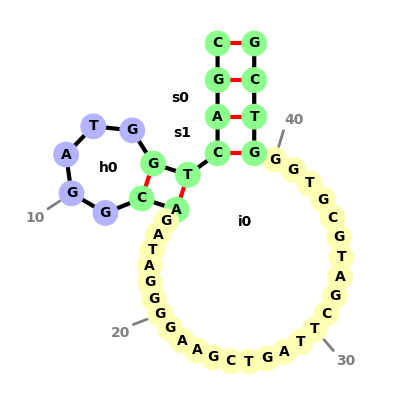

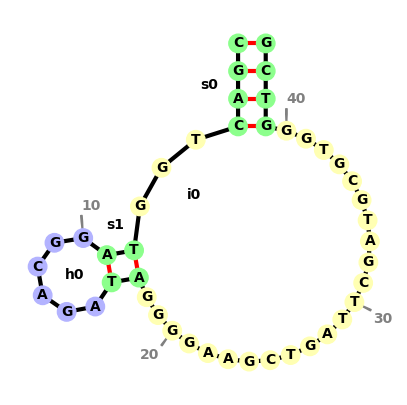

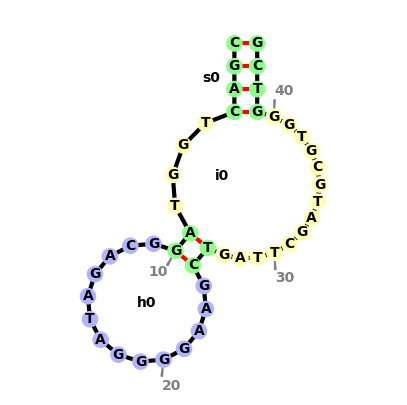

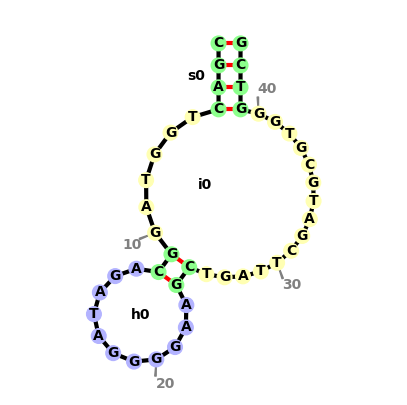

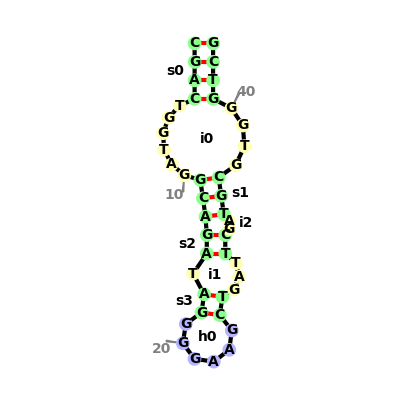

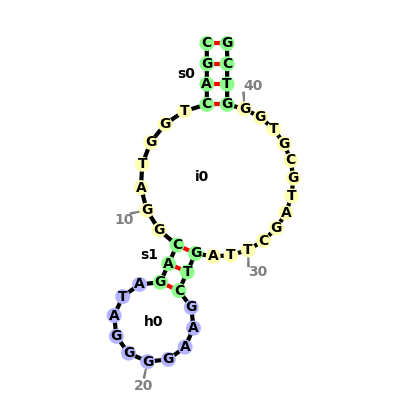

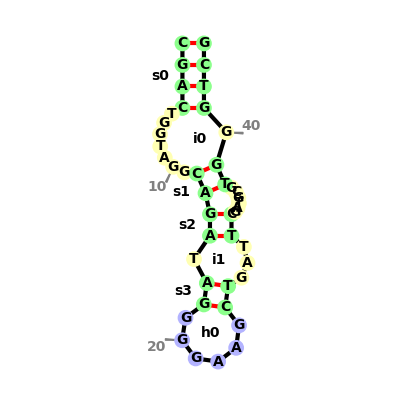

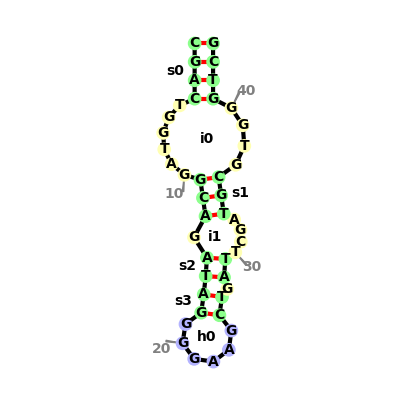

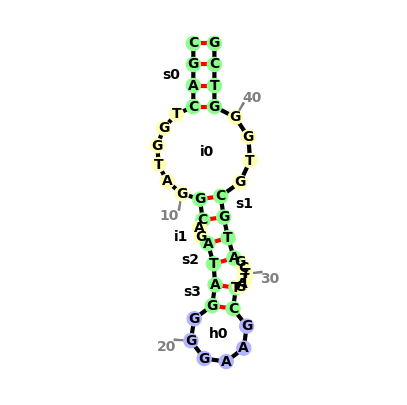

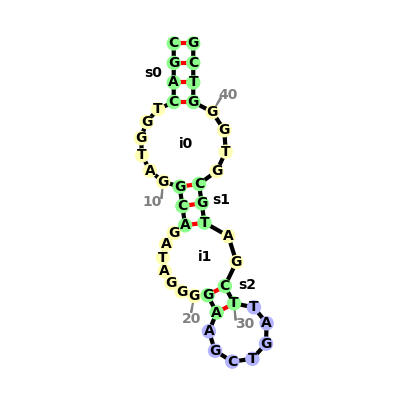

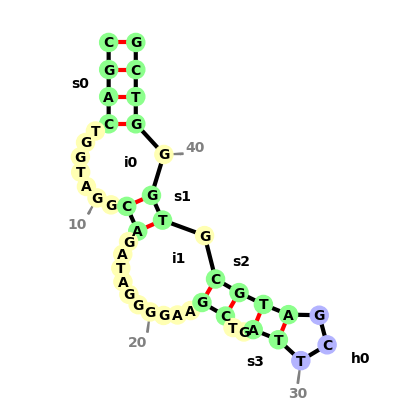

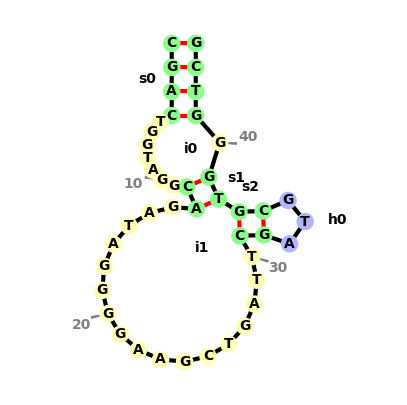

In [45]:
## Get plots
import numpy as np
import matplotlib.pyplot as plt
import forgi.visual.mplotlib as fvm
import forgi
from forgi.graph.bulge_graph import BulgeGraph

# Example sequence and structure
sequence = "CGACTGGTAGGCAACAGGGGAAGGGAGTTCTGCGTACGTGGGTCG"
structure = "(((((.((.(((.((((........)).)).).)).)).)))))"

# Convert sequence and structure to a BulgeGraph object
for st in structures_DB :
    plt.figure(figsize=(5,5))
    bg = BulgeGraph.from_dotbracket(st,strn15)
    fvm.plot_rna(bg, text_kwargs={"fontweight":"black"}, lighten=0.7,backbone_kwargs={"linewidth":3})
    plt.show()
# Plot using matplotlib

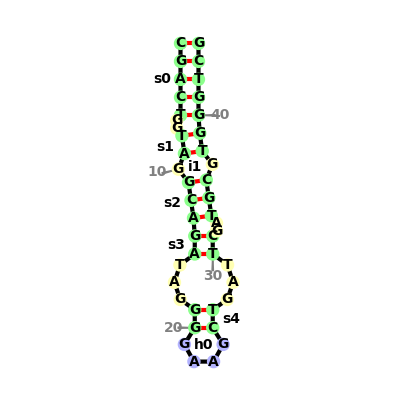

In [51]:
import RNA
def predict_secondary_structure(sequence, constraint = True):
    fc = RNA.fold_compound(sequence)

    
    if constraint:
        constraint_length = (len(sequence) -8)
        constr = "(" * 4 + '.'*constraint_length + ")" * 4
        fc.hc_add_from_db(constr)
    
    (ss, mfe) = fc.mfe()
    return ss, mfe



structure, mfe = predict_secondary_structure(strn15)
plt.figure(figsize=(5,5))
bg = BulgeGraph.from_dotbracket(structure, strn15)


fvm.plot_rna(bg, text_kwargs={"fontweight":"black"}, lighten=0.7,backbone_kwargs={"linewidth":3})
plt.show()


In [ ]:
''' seems slower
def build_BG_matrix(n, lst):
    BG = np.zeros((n, n), dtype=int)
    
    # Create indices
    i, j = np.indices((n, n))
    
    # Condition 1: i or j <= 4 and i + j = n + 1
    condition1 = np.logical_and(np.logical_or(i <= 4, j <= 4), i + j == n + 1)
    # Condition 2: i, j > 4 and lst[i] + lst[j] = 3 and |i - j| > 5
    tile_lst =  np.tile(lst, (n, 1))
    condition2 = np.logical_and(np.logical_and(i > 4, j > 4), np.logical_and(tile_lst + tile_lst.T == 3, np.abs(i - j) > 5))
    # Fill BG matrix
    BG[condition1 | condition2] = 1
    
    return BG
'''   

In [ ]:
   '''
                 for s in self.maximal_sets:
                min_ene, min_ene_structure = self.process_set(s)
                self.energies.append(min_ene) 
                self.min_energy_structures.append( min_ene_structure)
            for s in self.maximal_sets:
                        motifs_in_s = [item if isinstance(item, list) else [item] for item in list(itemgetter(*s)(self.motifs))]
                        structure_i = self.from_motifs_to_DB( motifs_in_s, self.sequence)
                        min_ene= compute_energy(self.sequence, structure_i  )
                        s_m = copy.deepcopy(s) 
                        flag = 1
                        new_min_ene = np.inf
                        while flag ==1 and len(s_m) >2:
                            flag = 0
                            for i in range(len(s_m)):
                                s_2 = copy.deepcopy(s_m)
                                #print('ala',s_2, i)
                                s_2.pop(i)
                                motifs_in_s_2 =  [item if isinstance(item, list) else [item] for item in list(itemgetter(*s_2)(self.motifs))]
                                #print(self.from_motifs_to_DB(motifs_in_s_2, self.sequence))
                                try:
                                    e_i =  compute_energy(self.sequence, self.from_motifs_to_DB(motifs_in_s_2, self.sequence))
                                except Exception:
                                    e_i = np.inf
                                
                                if e_i < new_min_ene:
                                    new_min_ene = e_i
                                    loc_i = i
                                    #print('sel', i)
                            if new_min_ene < min_ene:
                                #print('sm',s_m)
                                s_m.pop(loc_i)
                                min_ene = new_min_ene
                                flag = 1
                                    
                        self.energies.append(min_ene) 
                        motifs_in_s_m =  [item if isinstance(item, list) else [item] for item in list(itemgetter(*s_m)(self.motifs))]
                        self.min_energy_structures.append(self.from_motifs_to_DB(motifs_in_s_m , self.sequence))
                '''

 
            '''
            # naive apporach counting bp
            for m in maximal_sets:
                strc = []  # list of all bonds provided by motifs in maximal set
                energy = 0  # compute energy associated with given structure by summing the bond energy of bonds in that structure
                for i in m:
                    strc += motifs[i]
                unique_strc = list(set(strc))  # remove duplicates
                self.structures.append(unique_strc)  
                #print(len(self.structures))   
                for j in unique_strc:  # TO DO: adapt to additional type of bonds GA, TG, etc...
                    if j[0] in ['A', 'T']:
                        energy -= 1.5
                    else:
                        energy -= 3.6
                self.energies.append(energy)
                #print(len(self.energies))   
            '''
        

In [34]:
import numpy as np

class Aptamer_Fold:
    def __init__(self, sequence='ATA', n_tmpl=6, l_fix=4):
        self.l_fix= None # number of fixed base pairs in the 5' 3' bonds.
        self.n_tmpl = None
        self.n_wrld = None
        self.sequence = None # orginal sequnce in capital letters
        self.sqnc_num = None # original sequence converted in numbers
        self.B_g = None #matrix  storing all posible bonds between base-pairs
        self.dlt_g  = None #matrix sotring backbone bonds
        self.C_dct = {}#candidate dictionary, storing for each node in the tmpl its associated condadidates in wrld
        self.motifs = []  #list of all tmpl graphs found
        self.structures = None
     
        
    def init_candidate_dict(self):
        """
        Initializes a dictionary of candidate vertices for motifs.
        Each key represents a motif vertex, and the value is a list of candidate vertices from the world graph.
        """
       
        for i in range(self.n_tmpl):
            self.C_dct[f'{i}'] = list(range(self.n_wrld))
        return 

    def convert_sequence_to_numeric(self, sequence):
        """
        Converts a nucleotide string into a list of numeric representations.
        """
        mapping = {'A': 0, 'T': 3, 'C': 1, 'G': 2}
        self.sqnc_num = []
        for char in self.sequence:
            if char in mapping:
                self.sqnc_num.append(mapping[char])
            else:
                print('Invalid character. Only allowed nucleotides are ACTG')
                break
        return 

    def build_BG_matrix(self,):
        """
        Builds a binary adjacency matrix representing the BG motif structure.
        """
        self.B_g = np.zeros((self.n_wrld, self.n_wrld), dtype=int)
        for i in range(self.n_wrld):
            for j in range(i+1,self.n_wrld):
                if (i <= 3 or j <= 3) and (i + j == self.n_wrld - 1):
                    self.B_g[i, j] = 1
                    self.B_g[j, i] = 1
                if i > 3 and j > 3 and self.sqnc_num[i] + self.sqnc_num[j] == 3 and np.abs(i - j) >= self.n_tmpl - 1:
                    self.B_g[i, j] = 1
                    self.B_g[j, i] = 1
        return

    def motif_ngh_dct(self,):
        """
        Defines the neighborhood of each motif node.
        """
        graph = {}
        for i in range(self.n_tmpl):
            if i == 0:
                graph[str(i)] = [1, self.n_tmpl - 1]
            elif i == self.n_tmpl - 1:
                graph[str(i)] = [0, self.n_tmpl - 2]
            elif i == self.n_tmpl // 2 or i == self.n_tmpl // 2 - 1:
                graph[str(i)] = [i - 1, i + 1]
            else:
                graph[str(i)] = [i - 1, i + 1, self.n_tmpl - i - 1]
        return graph

    def backbone_bonds_matrix(self,):
        """
        Constructs the backbone bonds matrix.
        """
        array = np.zeros((self.n_wrld, self.n_wrld), dtype=int)
        array[np.diag_indices(self.n_wrld - 1)[1], np.diag_indices(self.n_wrld - 1)[0] + 1] = 1
        self.dlt_g = array + array.T
        
        return 

    def stats_filter(self,):
        """
        Filters candidate vertices based on statistical criteria.
        """
        ngh_mtf = np.ones(self.n_tmpl, dtype=int) if self.n_tmpl == 2 else 3 * np.ones(self.n_tmpl, dtype=int)
        ngh_mtf[[0, self.n_tmpl - 1, self.n_tmpl // 2, self.n_tmpl // 2 - 1]] = 2
        
        ngh_wrld = np.sum(self.dlt_g + self.B_g, axis=1)
        for i in range(self.n_tmpl):
            if i not in [0, self.n_tmpl - 1, self.n_tmpl // 2, self.n_tmpl // 2 - 1]:
                condition = np.where(ngh_wrld < ngh_mtf[i])
                self.C_dct[str(i)] = list(np.delete(np.array(self.C_dct[str(i)]), condition))
        return 

    def topology_filter(self, ):
        """
        Filters candidate vertices based on topological criteria.
        """
        nhg_mtf = self.motif_ngh_dct()
        self.dlt_g = self.backbone_bonds_matrix(self.n_wrld)
        self.B_g = self.build_BG_matrix(self.n_wrld, self.sqnc_num,self.n_tmpl)
        D_g = dlt_g + B_g
        for i in range(self.n_tmpl):
            for j in nhg_mtf[str(i)]:
                indx_remove = np.where(np.sum(D_g[self.C_dct[str(i)]][:,self.C_dct[str(j)]], axis=1) == 0)
                self.C_dct[str(i)] = list(np.delete(np.array(self.C_dct[str(i)]), indx_remove))
        return 

    def apt_filter(self, ):
        """
        Filters candidate vertices based on aptamer criteria.
        """
        nhg_mtf = self.motif_ngh_dct()
        motifs = []
        motifs_vect = []
        range_loop = self.C_dct[str(0)].copy()
        range_loop_2 = self.C_dct[str(self.n_tmpl // 2)].copy()
        for i in range_loop[:]:
            if self.l_fix - 1 <= i <= self.n_wrld - self.l_fix - 1:
                flag = False
                if np.any([i + count not in self.C_dct[str(self.n_tmpl // 2 - k)] for count, k in enumerate(range(self.n_tmpl // 2 - 1, 0, -1), 1)]):
                    for k in range(self.n_tmpl // 2):
                        try:
                             self.C_dct[str(k)].remove(i + k)
                        except ValueError:
                            pass
                else:
                    for j in range_loop_2:
                        if np.any([j + i not in  self.C_dct[str(self.n_tmpl // 2 + i)] for i in range(1, self.n_tmpl // 2)]):
                            for k in range(self.n_tmpl // 2, self.n_tmpl):
                                try:
                                    self.C_dct[str(k)].remove(j + k - self.n_tmpl // 2)
                                except ValueError:
                                    pass
                        elif (j >= i + 5 and j <= self.n_wrld - 5 and
                              np.all(self.B_g[list(range(i, i + self.n_tmpl // 2))][:, list(range(j + self.n_tmpl // 2 - 1, j - 1, -1))] == np.eye(self.n_tmpl // 2, dtype=int))):
                            flag = True
                            self.motifs.append([(i + k, j + self.n_tmpl // 2 - 1 - k) for k in range(self.n_tmpl // 2)])
                            
                    if not flag:
                        for k in range(self.n_tmpl // 2):
                            try:
                                self.C_dct[str(k)].remove(i + k)
                            except ValueError:
                                pass
        return 

    
    def compatible(self, motif_1, motif_2):
            if motif_1[0][0] < motif_2[0][0] and motif_1[-1][1] < motif_2[-1][1]:
                return False
            if motif_2[0][0] < motif_1[0][0] and motif_2[-1][1] < motif_1[-1][1]:
                return False
            tuple_list = motif_1 + motif_2
            compatible = True
            for i in range(len(tuple_list)):
                for j in range(i + 1, len(tuple_list)):
                    if 0 < len(set(tuple_list[i]).intersection(set(tuple_list[j]))) < 2:
                        compatible = False
                        break
            return compatible
            
            
    def find_maximal_sets(self, graph):
            self.maximal_sets = [[0]]
            graph_m = {str(0): graph[str(0)]}
            for i in range(1, len(graph)):
                flag = 0
                for j, m in enumerate(self.maximal_sets):
                    if i in graph_m[str(j)]:
                        m.append(i)
                        graph_m[str(j)] = list(set(graph_m[str(j)]) & set(graph[str(i)]))
                        flag = 1
                if flag == 0:
                    new_m = [i]
                    graph_m[f'{len(self.maximal_sets)}'] = graph[str(i)]
                    for j in range(i):
                        if j in graph_m[f'{len(self.maximal_sets)}']:
                            new_m.append(j)
                            graph_m[f'{len(self.maximal_sets)}'] = list(set(graph_m[f'{len(self.maximal_sets)}']) & set(graph[str(j)]))
                    self.maximal_sets.append(new_m)
            return self.maximal_sets    
            
            
              
    def find_largest_compatible_sets(self,motifs ):
        """
        Finds the largest compatible sets of motifs.
        """

        graph = {str(i): [i] for i in range(len(motifs))}
        for i, motifs1 in enumerate(motifs):
            for j, motifs2 in enumerate(motifs[i + 1:], i + 1):
                if self.compatible(motifs1, motifs2):
                    graph[str(i)].append(j)
                    graph[str(j)].append(i)
        maximal_sets = self.find_maximal_sets(graph)
        structures = []
        for m in maximal_sets:
            strc = []
            for i in m:
                strc += motifs[i]
            structures.append(list(set(strc)))
        return structures
            
    def from_motifs_to_DB(self,structures= None, lst= None):
            n_lst = len(lst)
            list_strings = []
            for structure in structures:
                    db_string = '('*4 + '.'*(n_lst-8) + ')'*4 
                    for bond in structure:
                        new_string = db_string[:bond[0]] + '(' + db_string[bond[0]+1:bond[1]]+ ')'  +db_string[bond[1]+1:]
                        db_string = new_string
                
                    list_strings.append( db_string)    
            return list_strings
            
    def fit_fold(self,sequence=strn15,  n_tmpl=4, l_fix=4):
        
            self.l_fix= l_fix # number of fixed base pairs in the 5' 3' bonds.
            self.n_tmpl = n_tmpl
            self.n_wrld = len(sequence)
            self.sequence = sequence # orginal sequnce in capital letters
            self.convert_sequence_to_numeric(self.sequence)
            self.build_BG_matrix()
            self.init_candidate_dict()
            #C2 = stats_filter(6, arr, C)
            #C3 = topology_filter(6, arr, C2)
            self.apt_filter()
            structures =  self.find_largest_compatible_sets(self.motifs)
            structures_DB = self.from_motifs_to_DB(structures, self.sequence)
            return structures_DB




In [36]:
# Example usage:
APT = Aptamer_Fold()
import time
start = time.time()
structures_DB2= APT.fit_fold( sequence=strn15,  n_tmpl=4, l_fix=4)
print(time.time()- start)

0.048720359802246094


In [46]:

    
for i  in range(len(structures_DB)):
         if structures_DB[i] != structures_DB2[i]:
             print('error')